## Homework 1

#### Michelle Appel (10170359)
#### Nils Hulzeboch (10749411)

#### 17-01-2018

### Theoretical Part [15 pts]

##### 1. Hypothesis Testing – The problem of multiple comparisons [ 5 points ]

(a) P($m^{th}$ experiment gives significant result | m experiments lacking power to reject $H_0$) = $1 - (1 - \alpha)^m$ (= $m \alpha$ when $\alpha$ is small)

Where m is the amount of experiments and $\alpha$ is the Type I error.

(b) P(at least one significant result | m experiments lacking power to reject $H_0$) = $\alpha$

##### 2. Bias and unfairness in Interleaving experiments [ 10 points ]

See image and explanation below:

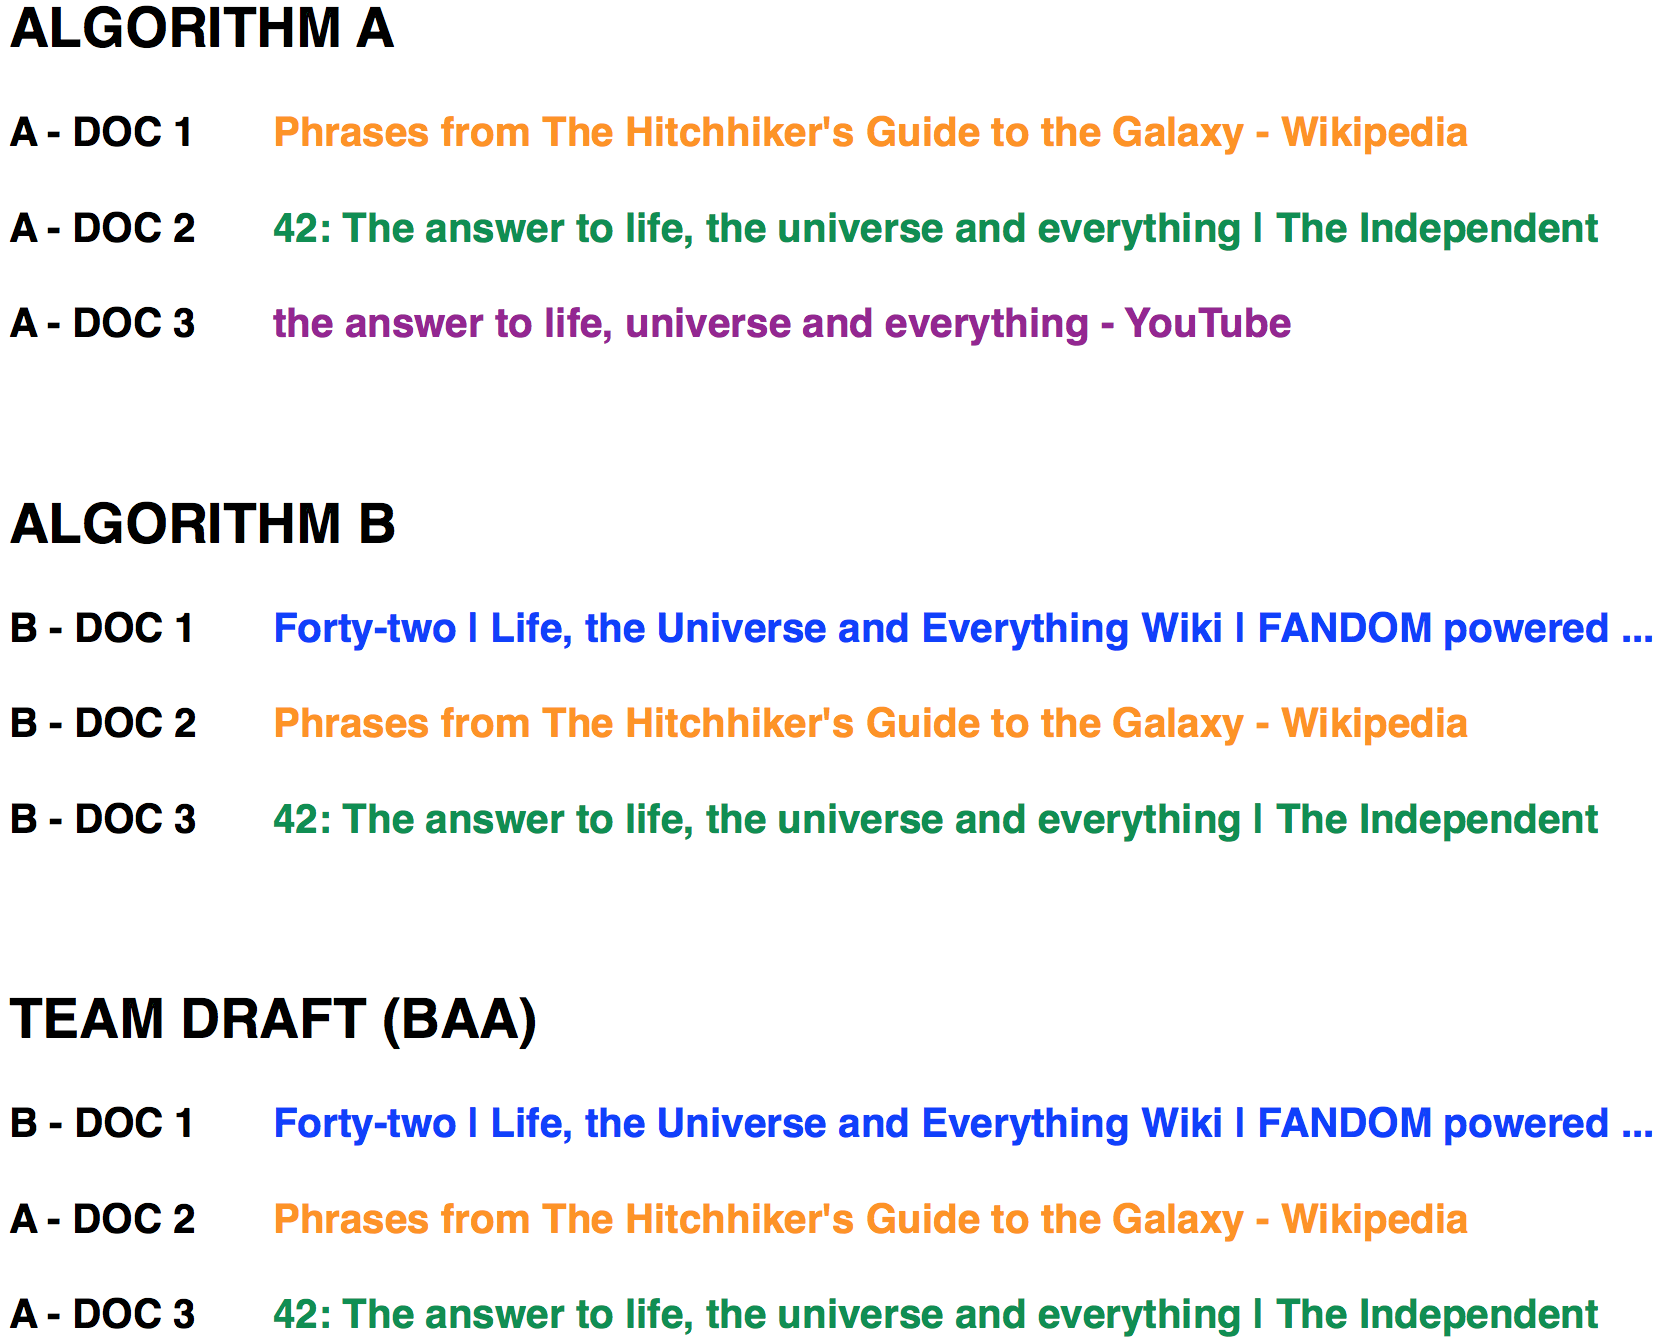

In [1]:
from IPython.display import Image
Image('example.png', width=400, height=100)

Explanation:
We have two algorithms A and B.
It is known that B is the best of the two.
Both have 3 documents:
- A has [1: Orange, 2: Green, 3: Purple]
- B has [1: Blue, 2: Orange, 3: Green]

We interleave them in a BAA scheme:
- B has [1: Blue (from B), 2: Orange (from A), 3: Green (from A)]


For random clicks, A will win 2/3 of the time, assuming the score is given to the algorithm that 'presented' the document while interleaving.

Additionaly, if we score based on which algorithm presents the document the highest in their list, A will again win: Blue is highest in B (+1 B), Orange is highest in A (+1 A), and Green is highest in A (+1 A). So A will still win 2/3 of the time, even while the order of documents is exactly the same as the order of B, the (known) better algorithm.

### Experimental Part [85 pts]

In [2]:
import itertools
import numpy as np
import random
import copy
import pandas as pd
from collections import defaultdict

##### Step 1: Simulate Rankings of Relevance for E and P (5 points)

In [3]:
relevances = ('N', 'R', 'HR') # the three relevance classes

# all combinations with length 5 of the relevance classes
combinations = list(itertools.combinations_with_replacement(relevances, 5))

# all permutations per combination
permutations = ()
for combination in combinations:
    permutations += tuple(set(itertools.permutations(combination)))
    
# ranking pairs of production P and experimental E
ranking_pairs = ()
for ranking_p in permutations:
    for ranking_e in permutations:
        if ranking_p != ranking_e:
            # if pairs are not the same, extend list with ranking pair
            ranking_pairs += ((ranking_p, ranking_e),)

##### Step 2: Implement Evaluation Measures (10 points)

##### Binary evaluation measures:
1. Precision at rank k,
2. Recall at rank k,
3. Average Precision <== eventually used for results

In [4]:
# precision = TP / (TP + FP)
def precision(ranking, rank=None):
    tp = ranking[:rank].count('R') + ranking[:rank].count('HR')
    fp = ranking[:rank].count('N')
    return tp / (tp + fp)

# recall = TP / (TP + FN)
def recall(ranking, no_relevant_documents, rank=None):
    if rank is None:
        rank = len(ranking)
    
    tp = ranking[:rank].count('R') + ranking[:rank].count('HR')
    fn = no_relevant_documents - tp
    return tp / (tp + fn)

# recall considering all documents
def recalls(ranking_pair, rank=None):
    no_relevant_documents = 0
    for ranking in ranking_pair:
        no_relevant_documents += ranking.count('R') + ranking.count('HR')
    
    recalls = ()    
    for ranking in ranking_pair:
        recalls += (recall(ranking=ranking, no_relevant_documents=no_relevant_documents, rank=rank),)
    return recalls

# average precision
def avg_precision(ranking):
    precisions = ()
    for rank in range(1, len(ranking)+1):
        if ranking[rank-1] == 'R' or ranking[rank-1] == 'HR':
            precisions += (precision(ranking, rank=rank),)

    if len(precisions) > 0:
        return np.mean(precisions)
    else:
        return 0

##### Multi-graded evaluation measures:

1. Normalized Discounted Cumulative Gain at rank k (nDCG@k),
2. Expected Reciprocal Rank (ERR).

In [5]:
# Normalized Discounted Cumulative Gain at rank k (nDCG@k)
def nDCGk(ranking, rank=None):
    if rank is None:
        rank = len(ranking)
    
    gains = ()
    for r, rel_grade in enumerate(ranking[:rank]):
        if rel_grade == 'N':
            rel_r = 0
        elif rel_grade == 'R':
            rel_r = 0.5
        elif rel_grade == 'HR':
            rel_r = 1
        
        gains += ((2**rel_r - 1)/(np.log2(2+r)),)
        
    return np.sum(gains)


# Mapping from relevance grades to probability of relevance
def R(rel_grade, g_max):
    if rel_grade == 'N':
        g = 0
    elif rel_grade == 'R':
        g = 1
    elif rel_grade == 'HR':
        g = 2

    return (2**g - 1)/(2**g_max)

# Expected Reciprocal Rank (ERR)
def ERR(ranking, rank=None):
    if rank is None:
        rank = len(ranking)
    
    g_max = 2
    
    return np.sum([([np.prod(((1/(r+1))*(1 - R(i_rel_grad, g_max))*R(r_rel_grad, g_max),)) 
                for i_rel_grad in ranking[:rank]],) 
                for r, r_rel_grad in enumerate(ranking[:rank])])

##### Step 3: Calculate the 𝛥measure (0 points)
    
For the three measures and all P and E ranking pairs constructed above calculate the difference: 𝛥measure = measureE-measureP. Consider only those pairs for which E outperforms P.

In [6]:
def delta_measure(ranking_pairs, evaluation_measure):
    delta_measures = ()
    ranking_pairs_e_wins = ()
    
    for ranking_pair in ranking_pairs:
        delta_measure = evaluation_measure(ranking_pair[1]) - evaluation_measure(ranking_pair[0])
        if delta_measure > 0:
            delta_measures += (delta_measure,)
            ranking_pairs_e_wins += (ranking_pair,)
            
    return np.mean(delta_measures), ranking_pairs_e_wins

In [7]:
d_measure_avgPrec, pairs_e_wins_avgPrec = delta_measure(ranking_pairs, avg_precision)
print('Delta measure of average precision', d_measure_avgPrec)

d_measure_nDCGk, pairs_e_wins_nDCGk = delta_measure(ranking_pairs, nDCGk)
print('Delta measure of nDCGk            ', d_measure_nDCGk)

d_measure_ERR, pairs_e_wins_ERR = delta_measure(ranking_pairs, ERR)
print('Delta measure of ERR              ', d_measure_ERR)

Delta measure of average precision 0.261224659563
Delta measure of nDCGk             0.661491247571
Delta measure of ERR               1.00161270187


##### Step 4: Implement Interleaving (15 points)

Implement 2 interleaving algorithms: (1) Team-Draft Interleaving OR Balanced Interleaving, AND (2), Probabilistic Interleaving. The interleaving algorithms should (a) given two rankings of relevance interleave them into a single ranking, and (b) given the users clicks on the interleaved ranking assign credit to the algorithms that produced the rankings.
(Note 4: Note here that as opposed to a normal interleaving experiment where rankings consists of urls or docids, in our case the rankings consist of relevance labels. Hence in this case (a) you will assume that E and P return different documents, (b) the interleaved ranking will also be a ranking of labels.)

In [8]:
# Balanced Interleaving
def balanced_interleaving(ranking_pair, rank=None):
    if rank is None:
        rank = len(ranking_pair[0]) + len(ranking_pair[1])
    
    p_first = random.randint(0,1)
    
    interleaved_ranking = ()
    picking_order = ()
    for p, e in zip(*ranking_pair):
        if p_first:
            interleaved_ranking += (p, e)
            picking_order += ('P', 'E')
        else:
            interleaved_ranking += (e, p)
            picking_order += ('E', 'P')
            
    return interleaved_ranking[:rank], picking_order
       
# Team-Draft Interleaving
def team_draft_interleaving(ranking_pair, rank=None):
    ranking_p = list(ranking_pair[0])
    ranking_e = list(ranking_pair[1])
                             
    if rank is None:
        rank = len(ranking_p) + len(ranking_e)
        
    team_p = ()
    team_e = ()
        
    interleaved_ranking = ()
    picking_order = ()
    for i in range(rank):
        if (len(team_p) < len(team_e)) or (len(team_p) == len(team_e) and random.randint(0,1)):
            rel_grade = ranking_p.pop(0)
            interleaved_ranking += (rel_grade,)
            team_p += (rel_grade,)
            picking_order += ('P',)
        else:
            rel_grade = ranking_e.pop(0)
            interleaved_ranking += (rel_grade,)
            team_e += (rel_grade,)
            picking_order += ('E',)
    
    return interleaved_ranking[:rank], picking_order

In [9]:
# test interleaving methods with an example
test_pair = (('HR', 'R', 'N', 'N', 'R'), ('N', 'N', 'R', 'N', 'R'))
print('Example:', test_pair, '\n')

bal_inter, bal_order = balanced_interleaving(test_pair)
print('Balanced interleaving:')
print(bal_inter)
print(bal_order, '(order of picking)\n')
      
team_inter, team_order = team_draft_interleaving(test_pair)
print('Team draft interleaving:')
print(team_inter)
print(team_order, '(order of picking)\n')

Example: (('HR', 'R', 'N', 'N', 'R'), ('N', 'N', 'R', 'N', 'R')) 

Balanced interleaving:
('HR', 'N', 'R', 'N', 'N', 'R', 'N', 'N', 'R', 'R')
('P', 'E', 'P', 'E', 'P', 'E', 'P', 'E', 'P', 'E') (order of picking)

Team draft interleaving:
('HR', 'N', 'N', 'R', 'R', 'N', 'N', 'N', 'R', 'R')
('P', 'E', 'E', 'P', 'E', 'P', 'E', 'P', 'P', 'E') (order of picking)



##### Step 5: Implement User Clicks Simulation (15 points)

In [10]:
'''
Random Click Model (RCM)
Any document can be clicked with the same (constant) probability p:
p = number of clicks / number of show documents,
and will be learned using the Yandex Click Log.
'''
def random_click_model(ranking, p):
    clicks = []
    for i in range(len(ranking)):
        if random.uniform(0, 1) <= p:
            clicks.append(i)
    return clicks

# example
test_docs = ('HR', 'N', 'R', 'N', 'N', 'R', 'N', 'N', 'N', 'N')
print(random_click_model(test_docs, 0.3))

[0, 6, 7]


In [11]:
'''
Position-Based Model (PBM)
Any document can be clicked with a probability that is calculated
by multiplying:
- Examination (gamma):  the probability of examining a document 
- Attractiveness (alpha): the probability of a document to be attractive
These parameters are  learned using the Yandex Click Log,
but the attractiveness is not directly used.
Instead it is estimated using the learned parameters (later in this doc).
'''
def position_based_model(ranking, alphas, gammas):

    clicks = []
    for i in range(len(ranking)):
        if ranking[i] == 'HR':
            alpha = alphas[0]
        elif ranking[i] == 'R':
            alpha = alphas[1]
        else:
            alpha = alphas[2]
        p = alpha * gammas[i]
        if random.uniform(0, 1) <= p:
            clicks.append(i)

    return clicks

# example
test_docs = ('HR', 'HR', 'R', 'N', 'N', 'R', 'N', 'N', 'N', 'N')
test_alphas = [1, 0.9, 0.3]
test_gammas = [1, 0.9, 0.7, 0.7, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5]
print(position_based_model(test_docs, test_alphas, test_gammas))

[0, 1, 6, 7]


In [12]:
'''
A Session class to store sessions, which consist of
- one query, containing 10 document urls, and
- a list of clicked documents (can be empty)

This class is used to transform the dataset, consisting of
- queries (SessionID TimePassed TypeOfAction QueryID RegionID ListOfURLs), and
- clicks (SessionID TimePassed TypeOfAction URLID)
into a suitable format to learn the parameters for the click models.
'''
class Session:
    def __init__(self, documents, query_id):
        self.documents = documents
        self.clicks = []
        self.clicks_urls = []
        self.query_id = query_id
        
    def __repr__(self):
        return 'Indexes of clicked documents: ' + str(self.clicks)
    
    # add the index (rank) of clicked document to list of clicks
    def add_click(self, click):
        try:
            self.clicks.append(self.documents.index(click))
            self.clicks_urls.append(click)
        except ValueError:
            pass # if the click is not one of the documents, ignore

In [13]:
# load dataset and transform into list of Sessions
def load_data_set():
    all_actions = []
    with open('YandexRelPredChallenge.txt', 'r') as f:
        for line in f:
            all_actions.append(line.split("\n")[0].split('\t'))

    all_sessions = []
    previous_session = 'init'
    for i in range(len(all_actions)):
        if all_actions[i][2] == 'Q':
            # if action is query, store previous session and create new
            all_sessions.append(previous_session)
            previous_session = Session(all_actions[i][5:],
                                        all_actions[i][3])
        else:
            # if action is click, add click to previous session
            previous_session.add_click(all_actions[i][3])
        
    all_sessions.pop(0) # delete first ('init') element
    print("Amount of sessions:", len(all_sessions))
    
    return all_sessions

all_sessions = load_data_set()

Amount of sessions: 42651


In [14]:
'''
Calculate (constant) click probability for Random Click Model,
using the Yandex Click Log database:
click probability = 
(total amount of documents shown in all sessions /
total amount of clicks in all sessions)
'''
def calculate_click_prob(all_sessions):
    documents_shown = 0
    clicks_amount = 0
    for session in all_sessions:
        documents_shown += len(session.documents)
        clicks_amount += len(session.clicks)
    click_probability = float(clicks_amount) / documents_shown
    
    print("Total amount of documents shown:", documents_shown)
    print("Total amount of clicks:         ", clicks_amount)
    print("Click probability               ", round(click_probability, 3))
    
    return click_probability
          
click_probability = calculate_click_prob(all_sessions)

Total amount of documents shown: 426510
Total amount of clicks:          56638
Click probability                0.133


In [15]:
'''
A dictionary to store all query-document pairs, and keep track of their:
- alpha
- clicks
- ranks
Used by the EM algorithm to learn alpha.
'''
def document_query_pairs(all_sessions = all_sessions, init_alpha = 0):
    document_query_pairs = defaultdict(
        lambda: defaultdict(
            lambda: {'alpha':init_alpha, 'clicks':[], 'ranks':[]}))

    for session in all_sessions:
        for document in session.documents:
            document_query_pairs[session.query_id][document]['clicks'].append(1 if document in session.clicks_urls else 0)
            document_query_pairs[session.query_id][document]['ranks'].append(session.documents.index(document))
            
    return document_query_pairs

In [16]:
'''
The EM algorithm, used for estimating the best alpha and gamma values
for the Position-Based Model.
It used the closed form solutions from the book to update the
alpha and gamma values.
'''
def em_algorithm(all_sessions, iterations = 5,
                 init_alpha = 0.5, init_gamma = 0.5):
    
    # initialize alphas (attractiveness)
    alphas = document_query_pairs(init_alpha=init_alpha)
    
    # initialize gammas (examination)
    gammas = [init_gamma]*10

    # loop i times over complete dataset
    for i in range(iterations):
        print('Iteration:', i)

        # calculate all new alpha values
        new_alphas = copy.deepcopy(alphas)
        for query_id, doc_urls in alphas.items():
            for doc_url, properties in doc_urls.items():
                alpha = properties['alpha']
                clicks = properties['clicks']
                ranks = properties['ranks']

                sum_over_sessions = 0
                for i in range(len(clicks)):
                    click_doc = clicks[i]
                    rank = ranks[i]
                    sum_over_sessions += (click_doc + (1 - click_doc) * 
                        (((1 - gammas[rank]) * alpha) / 
                        (1 - gammas[rank] * alpha)))
                new_alpha = 1/len(clicks) * sum_over_sessions
                new_alphas[query_id][doc_url]['alpha'] = new_alpha

        # calculate all new gamma values
        new_gammas = []
        for i in range(len(gammas)):
            sum_over_sessions = 0
            for session in all_sessions:
                documents = session.documents
                clicks = session.clicks
                query_id = session.query_id
                doc_url = documents[i]
                alpha = alphas[query_id][doc_url]['alpha']

                if i in clicks:
                    click_doc = 1
                else:
                    click_doc = 0

                sum_over_sessions += (click_doc + (1 - click_doc) * 
                    (((1 - alpha) * gammas[i]) / 
                    (1 - gammas[i] * alpha)))
            new_gamma = 1/len(all_sessions) * sum_over_sessions
            new_gammas.append(new_gamma)

        # simultaneously update new alpha and gamma values
        alphas = new_alphas
        gammas = new_gammas

    return alphas, gammas

In [17]:
# run the EM algorithm for 10 iterations
alphas, gammas = em_algorithm(all_sessions, iterations=10)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


##### Step 6: Simulate Interleaving Experiment (10 points)

In [18]:
#TODO ADD COMMENT

def grade_alphas(document_query_pairs=alphas, HR_cr = 0.95, R_cr = 0.6):

    HR_alphas = []
    R_alphas = []
    N_alphas = []

    for query_id in document_query_pairs:
        for document_id in document_query_pairs[query_id]:
            if np.mean(document_query_pairs[query_id][document_id]['clicks']) >= HR_cr:
                HR_alphas.append(document_query_pairs[query_id][document_id]['alpha'])
            elif np.mean(document_query_pairs[query_id][document_id]['clicks']) >= R_cr:
                R_alphas.append(document_query_pairs[query_id][document_id]['alpha'])
            else:
                N_alphas.append(document_query_pairs[query_id][document_id]['alpha'])
                
    return np.mean(HR_alphas), np.mean(R_alphas), np.mean(N_alphas)

grade_alphas = grade_alphas(document_query_pairs=alphas, HR_cr=0.95, R_cr=0.6)

In [19]:
#TODO ADD COMMENT

def simulate_random_click_model(ranking_pairs=ranking_pairs, n_simulations=1):

    P_wins = 0
    E_wins = 0
    
    for ranking_pair in ranking_pairs:
        
        tdi_ranking = team_draft_interleaving(ranking_pair)
        P_count = 0
        E_count = 0
        
        for i in range(n_simulations):
            random_click = random_click_model(tdi_ranking[0], 0.3)
            for click in random_click:
                if tdi_ranking[1][click] == 'P':
                    P_count += 1
                else:
                    E_count += 1

        if P_count >= E_count:
            P_wins += 1
        if P_count <= E_count:
            E_wins += 1
                
    return E_wins/P_wins

In [20]:
'''
Simulate an experiment using the Position-Based Model.

'''
def simulate_position_based_click_model(ranking_pairs=ranking_pairs,
        examinations=gammas, attractiveness=(1, 1, 1), n_simulations=1):
    
    P_wins = 0
    E_wins = 0
    prop = 0
    
    for ranking_pair in ranking_pairs:
        
        tdi_ranking = team_draft_interleaving(ranking_pair, rank=10)
        P_count = 0
        E_count = 0
        
        for i in range(n_simulations):
            for click in position_based_model(ranking=tdi_ranking[0], 
                    alphas=attractiveness, gammas=examinations):
                
                if tdi_ranking[1][click] == 'P':
                    P_count += 1
                else:
                    E_count += 1
                
        if P_count >= E_count:
            P_wins += 1
        if P_count <= E_count:
            E_wins += 1
    
    return E_wins/P_wins

In [22]:
ranking_pairs_e_wins_methods = (pairs_e_wins_avgPrec[:5000],
                                pairs_e_wins_nDCGk[:5000],
                                pairs_e_wins_ERR[:5000])

evaluation_measures = ('average precision', 'nDCG at rank k', 'ERR')

measure_methods = (avg_precision, nDCGk, ERR)

d_measures = []
click_measures = []

for ranking_pairs_e_wins, evaluation_measure in zip(ranking_pairs_e_wins_methods, evaluation_measures):
    print('Ranking pairs obtained by taking all positive delta measures of {}:'.format(evaluation_measure))

    for measure_method, method_name in zip(measure_methods, evaluation_measures):
        d_measure = delta_measure(ranking_pairs_e_wins, measure_method)[0]
        d_measures.append(d_measure)
        print(method_name + ' '*(43 - len(method_name)), d_measure)
    print()
    
    click_measure = simulate_random_click_model(ranking_pairs = ranking_pairs_e_wins, 
                                      n_simulations = 100)
    click_measures.append(click_measure)
    print('E/P ratio of the random click model        ', click_measure)
    
    click_measure = simulate_position_based_click_model(ranking_pairs = ranking_pairs_e_wins,
                                              attractiveness = grade_alphas, 
                                              n_simulations = 100)
    
    click_measures.append(click_measure)
    print('E/P ratio of the position based click model', click_measure)
    print()

Ranking pairs obtained by taking all positive delta measures of average precision:
average precision                           0.408863333333
nDCG at rank k                              1.05982621447
ERR                                         1.63714533578

E/P ratio of the random click model         0.9738863287250384
E/P ratio of the position based click model 64.84210526315789

Ranking pairs obtained by taking all positive delta measures of nDCG at rank k:
average precision                           0.435660896932
nDCG at rank k                              1.00946597745
ERR                                         1.58529206323

E/P ratio of the random click model         0.9857032457496137
E/P ratio of the position based click model 22.857142857142858

Ranking pairs obtained by taking all positive delta measures of ERR:
average precision                           0.440506763053
nDCG at rank k                              1.0484768629
ERR                                         1.5

##### Step 7: Results and Analysis (30 points)

Compare the results of the offline experiments (i.e. the values of the 𝛥measure) with the results of the online experiment (i.e. proportion of wins), analyze them and reach your conclusions regarding their agreement.
Use easy to read and comprehend visuals to demonstrate the results;
Analyze the results on the basis of
the evaluation measure used,
the interleaving method used,
the click model used.
Report and ground your conclusions.
(Note 8: This is the place where you need to demonstrate your deeper understanding of what you have implemented so far; hence the large number of points assigned. Make sure you clearly do that so that the examiner of your work can grade it accordingly.)

### Summary
In this exercise, a comparison between offline and online evaluation methods for ranking was made. The offline evaluation measures consisted of average precision, Normalized Discounted Cumulative Gain at rank k (nDCG@k), and Expected Reciprocal Rank (ERR). The online evaluation measure was the proportion of wins of two click models, a Random Click Model (RCM) and a Position-Based Model (PBM).

#### Training
To obtain reasonable parameters for both click models, the Yandex Click Log File was used for training. For the RCM, the (constant) click probability was calculated. For the PBM, the examination and attractiveness parameters were calculated.

#### Transformation / assumptions
The attractiveness values were not directly used, because there was no direct mapping between the Yandex Click Log File (query-documents pairs) and the practical data used for this assignment (relevance labels). However, the values are used in the following way. For this assignment, three attractiveness values are used: ’N’ (not relevant), ‘R’ (relevant), and ‘HR’ (highly relevant). The following assumptions were made: a document is highly relevant if it is clicked on $>=95\%$ of its occurrences, relevant if it is clicked on $>=60\%$ of its occurrences, and irrelevant if it is clicked on $<60\%$ of its occurrences. Using these assumptions, the average of all attractiveness parameters in each category could be used as the parameters for the click simulation. The examination values learned from the Yandex Click Log File did not need a transformation and could be used directly (since in both datasets the amount of shown documents / labels is 10).

#### Evaluation
Using both click models, along with Team-Draft Interleaving, the average proportion of wins of algorithm E compared to P could be measured in online experiments. The following paragraph describes the results of these experiments, and compares them with the offline experiments. A Pearson correlation test was done to measure the correlation between offline and online measures.

### Results

#### Offline
- Average precision
- Normalized Discounted Cumulative Gain at rank k (nDCG@k)
- Expected Reciprocal Rank (ERR)


#### Online
- Random Click Model (RCM)
- Position-Based Model (PBM)

#### Comparison


### Conclusion & Discussion

- We tried similar experiments with Balanced Interleaving, but got almost the same results, so we chose to use Team-Draft Interleaving for our final result. When you look at both methods this is quite obvious, since every document is treated uniquely. Balanced and Team-Draft Interleaving are therefore very equal, maybe the latter has one document pair swapped (sometimes you see two ‘P’s or ‘E’s after each other in Team-Draft interleaving).
- In the future, it would be interesting to use the real attractiveness parameters and test a PBM on a dataset similar to the Yandex Click Log File, as this is more realistic than the made-up data that was used.


In [24]:
# calculate the Pearson correlation between offline and online measures

d_measures_copy = copy.deepcopy(d_measures)
click_measures_copy = copy.deepcopy(click_measures)

avg_precisions = []
nDCGks = []
ERRs = []

random_click_models = []
position_based_click_models = []

for i in range(len(evaluation_measures)):
    avg_precisions.append(d_measures_copy.pop(0))
    nDCGks.append(d_measures_copy.pop(0))
    ERRs.append(d_measures_copy.pop(0))
    
    
for i in range(len(evaluation_measures)):
    random_click_models.append(click_measures_copy.pop(0))
    position_based_click_models.append(click_measures_copy.pop(0))    

for y in [random_click_models, position_based_click_models]:
    for x in [avg_precisions, nDCGks, ERRs]:
        print(np.corrcoef(y, x)[0, 1])

0.757566943858
0.113511442912
-0.780645259176
-0.937304497737
0.815414356486
0.924107654671
